In [1]:
#[220505_1137]UPDATED 지금까지 구성을 전부 정리함
from Bio import Entrez
from Bio import SeqIO
from Bio.Align.Applications import MuscleCommandline
from pathlib import Path

Entrez.email = "nagabuti13@naver.com"

#[220502_1717]CREATED getIdList: NCBI에서 keyword를 검색하여 script의 id를 추출한다
#[220512_1210]NOTED esearch()의 파라미터에 id의 개수를 조절하는 retmax 파라미터가 존재
def getIdlist(database, keyword):
    handle = Entrez.esearch(db = database, retmax = 30, term = keyword)
    records = Entrez.read(handle)
    return records["IdList"]

#[220505_1717]CREATED getFastaFile: NCBI에서 id를 검색하여 얻은 fasta파일을 컴퓨터에 저장한다
def getFasta(id):
    handle = Entrez.efetch(db = 'nucleotide', id = id, rettype = 'fasta', retmode = 'text')
    record = SeqIO.read(handle, 'fasta')
    print('## creating ' + record.id + '.fasta...')
    with open(record.id + '.fasta', 'w') as f:
        f.write('>' + record.description + '\n')
        f.write(str(record.seq) + '\n')
    
#[220502_1717]CREATED getAlnFile: 다중염기서열을 생성하는 툴 중 하나인 MUSCLE로 aln파일을 생성한다
def getAln(filename):
    muscle_exe = '/Users/biosmu/muscle3.8.31_i86darwin64'
    cmd_line = MuscleCommandline(muscle_exe, input = filename,
                             out = Path(filename).stem + '.aln', clw = ' ')
    print(cmd_line)
    stdout, stderr = cmd_line()   

## 원본과 예측값 비교를 위한 시각화 

In [3]:
getAln('all_pisces_coi.fasta')

/Users/biosmu/muscle3.8.31_i86darwin64 -in all_pisces_coi.fasta -out all_pisces_coi.aln -clw


## 데이터 전처리 및 DataFrame 구성

* DataFrame의 Target 구성을 위해 종(species) 크롤링 

In [4]:
from Bio import SeqIO
from Bio import Entrez
from Bio import GenBank

Entrez.email = "nagabuti13@naver.com"

#[220509_1517]CREATED ncbi에서 alignment의 각 record genbank파일로부터 종 이름을 반환
def getGenbank(id):
    handle = Entrez.efetch(db = "nucleotide", rettype = "gb", id = id, retmode = "text")
    r = GenBank.read(handle)
    return r

In [5]:
from Bio import AlignIO
import pandas as pd

alignment = AlignIO.read('all_pisces_coi.aln', 'clustal')
sum_s, sum_e = 0, 0
length = []
count = 0
start, end = 0, 0
k = 3
mer = ''
for record in alignment:
    count = 0
    for i in range(len(record.seq)):
        mer = record.seq[i:i + k]
        if(count == 1 and mer.count('-') == 2):
            end = i
            break
        elif(mer.count('-') == 3):
            continue
        elif(count != 1):
            start = i + k - 1
            count = 1
        print(start, end)
        length.append(end - start + 1)
length.sort()
pd.DataFrame(length).value_counts()

66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0
66 0


KeyboardInterrupt: 

* DataFrame의 열(feature) 구성을 위해 k-mer(k = 3)을 활용

In [5]:
#[220508_1659]CREATED Sequecne Alignment를 다룰 수 있는 모듈 호출
from Bio import AlignIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans

alignment = AlignIO.read('all_pisces_coi.aln', 'clustal')

k = 3
dict = {}
df = pd.DataFrame()
#[220513_1700]CREATED AGCT 외의 염기를 처리하기 위해 사전형에 key, value로 저장 
base_dict = {'A':'A', 'G':'G', 'C':'C', 'T':'T', 'U':'U',
'Y':'T', 'R':'A', 'S':'C', 'W':'A', 'K':'G', 'M':'C', 'B':'C', 'D':'G', 'H':'T', 'V':'C', 'N':'A'}

#[220508_1735]CREATED k = 3인 kmer의 모든 경우의 수를 사전형에 미리 저장
def init(datatype):
    for i in range(4):
        for j in range(4):
            for k in range(4):
                datatype[list(base_dict.keys())[i] + list(base_dict.keys())[j] + list(base_dict.keys())[k]] = 0
    #datatype['---'] = 0
    #[220509_1517]CREATED k-means는 unsupervised이지만, 여기서는 표본의 타겟을 ncbi에서부터 추출가능하므로 타겟 피처 생성
    datatype['target'] = 0

init(df)

#[220508_1738]CREATED 'all.aln' 안의 모든 개체의 염기서열을 k = 3인 kmers로 구분짓고 빈도를 사전에 저장
for i, record in enumerate(alignment):
    init(dict)
    #[220509_1517]NOTED getOrganism() 호출
    dict['target'] = getGenbank(record.id).organism
    index = 0
    if(len(record.seq[50:511]) >= k):
        while(index + k <= 461):
            mer = record.seq[50:511][index:index + k]
            if(mer.find('-') != -1):
                #dict['---'] += 1
                index += 1
                continue
            #[220513_1810]CREATED kmer 문자열을 base_dict의 values로 교체
            for p in range(k):
                mer = mer.replace(mer[p], base_dict.get(mer[p]))
                
            dict[mer] += 1
            index += 1
    df.loc[i] = dict
    
#[220508_2232]NOTED 총 문자열 길이를 L이라 하면, kmers의 개수: L - k + 1 ex) 1542 - 3 + 1 = 1540개
#[220513_1623]NOTED 1542 -> 17377(하나의 시퀀스의 실제 길이: 약 600bp이지만 MSA의 경우 '-'로 인해 길어져 보인다.)

In [6]:
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,target
0,3,4,11,12,1,9,9,8,7,1,...,4,6,5,6,8,16,7,9,23,Petromyzon marinus
1,3,4,11,13,1,9,9,8,7,1,...,4,6,6,6,9,16,7,10,25,Petromyzon marinus
2,3,4,11,12,1,9,9,8,7,1,...,4,6,6,6,9,16,7,11,27,Petromyzon marinus
3,3,4,11,13,1,9,9,8,7,1,...,4,6,6,6,9,16,7,10,25,Petromyzon marinus
4,3,4,11,13,1,9,9,8,7,1,...,4,6,6,6,8,16,7,10,25,Petromyzon marinus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,4,1,10,18,0,6,11,5,7,2,...,4,7,1,9,14,14,10,10,18,Peprilus paru
525,4,1,10,18,0,6,11,5,7,2,...,4,7,1,9,14,14,10,10,18,Peprilus paru
526,4,1,10,18,0,6,11,5,7,2,...,4,7,1,9,14,14,10,10,18,Peprilus paru
527,4,1,10,18,0,6,11,5,7,2,...,4,7,1,9,14,14,10,10,18,Peprilus paru


In [15]:
#[220509_1621]CREATED 레이블 인코딩으로 종 이름 -> 고유 숫자
from sklearn.preprocessing import LabelEncoder

a = df['target']
encoder = LabelEncoder()
labels = encoder.fit_transform(a)
#[220509_1622]NOTED* 종의 총 개수 = 19인 것을 알 수 있으므로 KMeans의 파라미터인 n_clusters를 14 -> 19로 수정
#[220513_1830]NOTED 종: 101개
#[220519_1745]NOTED 종: 9개
print(labels)

df['target'] = labels
df.head()

[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 5 5 5 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 1 1 1 1 1 1 

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TTA,TTG,TTC,TTT,target,lda_x,lda_y,tsne_x,tsne_y,cluster
0,3,4,11,12,1,9,9,8,7,1,...,16,7,9,23,7,20.701386,34.803504,-11.091155,-20.753036,1
1,3,4,11,13,1,9,9,8,7,1,...,16,7,10,25,7,17.968170,35.170199,-12.056692,-19.134464,1
2,3,4,11,12,1,9,9,8,7,1,...,16,7,11,27,7,22.363416,35.507092,-14.047276,-18.564112,1
3,3,4,11,13,1,9,9,8,7,1,...,16,7,10,25,7,20.694820,35.190072,-13.117618,-19.389843,1
4,3,4,11,13,1,9,9,8,7,1,...,16,7,10,25,7,19.500236,35.659094,-11.595386,-19.309942,1


### LDA 차원축소 사용했을 때

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components = 2)
lda.fit(df.loc[:, :'TTT'], df['target'])
ma_lda = lda.transform(df.loc[:, :'TTT'])
print(ma_lda.shape)

df['lda_x'] = ma_lda[:, 0]
df['lda_y'] = ma_lda[:, 1]
df.head()

(529, 2)


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCG,TCC,TCT,TTA,TTG,TTC,TTT,target,lda_x,lda_y
0,3,4,11,12,1,9,9,8,7,1,...,5,6,8,16,7,9,23,Petromyzon marinus,20.701386,34.803504
1,3,4,11,13,1,9,9,8,7,1,...,6,6,9,16,7,10,25,Petromyzon marinus,17.968170,35.170199
2,3,4,11,12,1,9,9,8,7,1,...,6,6,9,16,7,11,27,Petromyzon marinus,22.363416,35.507092
3,3,4,11,13,1,9,9,8,7,1,...,6,6,9,16,7,10,25,Petromyzon marinus,20.694820,35.190072
4,3,4,11,13,1,9,9,8,7,1,...,6,6,8,16,7,10,25,Petromyzon marinus,19.500236,35.659094


In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average = 'macro')
    recall = recall_score(y_test, pred, average = 'macro')
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.2f}, 정밀도: {1:.2f}, 재현율: {2:.2f}'.format(accuracy, precision, recall))
    
    
svm_2 = SVC(kernel = 'linear') 
#[220715_1739]NOTED 모델 생성

X = df[['lda_x', 'lda_y']]
y = df['target']

scaler = StandardScaler()
new_X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.2)
#[220715_1740]NOTED 학습 데이터와 테스트 데이어셋으로 무작위 분리한 뒤 정규화

parameters = {'C':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'gamma':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
#[220715_1741]NOTED 파라미터 후보 설정

grid_svm = GridSearchCV(svm_2, param_grid = parameters, cv = 5)
grid_svm.fit(X_train, y_train)  
#[220711_1658]NOTED 검증 데이터셋 + 학습 데이터셋 = 원래 학습 데이터셋

print(grid_svm.best_params_)
print(grid_svm.best_score_)
best_pred = grid_svm.best_estimator_.predict(X_test)
get_clf_eval(y_test, best_pred)

/Users/biosmu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


{'C': 1, 'gamma': 1}
0.9905602240896358
오차 행렬
[[ 3  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0]
 [ 0  0 37  0  0  0  0  0]
 [ 0  0  0 12  0  0  0  0]
 [ 0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0  0 29]]
정확도: 0.99, 정밀도: 0.84, 재현율: 0.88


/Users/biosmu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### t-sne 차원축소 사용했을 때

In [9]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, perplexity = 30).fit_transform(df.loc[:,:'TTT'])

df['tsne_x'] = tsne[:, 0]
df['tsne_y'] = tsne[:, 1]
df.head()

/Users/biosmu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/biosmu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCT,TTA,TTG,TTC,TTT,target,lda_x,lda_y,tsne_x,tsne_y
0,3,4,11,12,1,9,9,8,7,1,...,8,16,7,9,23,Petromyzon marinus,20.701386,34.803504,-11.091155,-20.753036
1,3,4,11,13,1,9,9,8,7,1,...,9,16,7,10,25,Petromyzon marinus,17.968170,35.170199,-12.056692,-19.134464
2,3,4,11,12,1,9,9,8,7,1,...,9,16,7,11,27,Petromyzon marinus,22.363416,35.507092,-14.047276,-18.564112
3,3,4,11,13,1,9,9,8,7,1,...,9,16,7,10,25,Petromyzon marinus,20.694820,35.190072,-13.117618,-19.389843
4,3,4,11,13,1,9,9,8,7,1,...,8,16,7,10,25,Petromyzon marinus,19.500236,35.659094,-11.595386,-19.309942


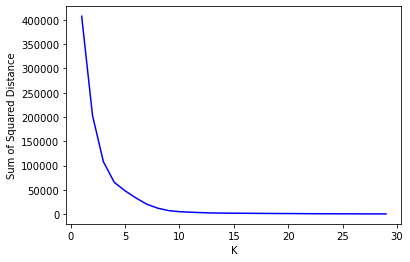

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 30)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 1000)
    km.fit(df[['tsne_x', 'tsne_y']])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220805_1649]CREATED k = 6일 때가 최적 but 실제는 9

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

ks = range(2, 20)
for k in ks:
    kmeans = KMeans(n_clusters = k, max_iter=500)
    kmeans.fit(df[['tsne_x', 'tsne_y']])
    df['cluster'] = kmeans.labels_
    df['sil_sam'] = silhouette_samples(df[['tsne_x', 'tsne_y']], df['cluster'])
    sil_tot = silhouette_score(df[['tsne_x', 'tsne_y']], df['cluster'])
    sil_clu = df.groupby('cluster')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    print('score: {0:.3f}'.format(score_k))
    print('---------------')
    df.drop('cluster', axis = 1, inplace = True)
    df.drop('sil_sam', axis = 1, inplace = True)
#[220801_1637]CREATED 전체 실루엣 계수 평균이 높으면서 군집 별 실루엣 계수와 크게 차이나지 않는 k 값은 9이다.

전체 실루엣 계수 평균: 0.487
군집 별 실루엣 계수 평균: 
cluster
0    0.533055
1    0.453351
Name: sil_sam, dtype: float32
score: 0.040
---------------
전체 실루엣 계수 평균: 0.546
군집 별 실루엣 계수 평균: 
cluster
0    0.474991
1    0.691063
2    0.527493
Name: sil_sam, dtype: float32
score: 0.078
---------------
전체 실루엣 계수 평균: 0.587
군집 별 실루엣 계수 평균: 
cluster
0    0.597245
1    0.678110
2    0.564155
3    0.494601
Name: sil_sam, dtype: float32
score: 0.054
---------------
전체 실루엣 계수 평균: 0.630
군집 별 실루엣 계수 평균: 
cluster
0    0.586215
1    0.619148
2    0.796447
3    0.494601
4    0.942984
Name: sil_sam, dtype: float32
score: 0.134
---------------
전체 실루엣 계수 평균: 0.667
군집 별 실루엣 계수 평균: 
cluster
0    0.586215
1    0.776521
2    0.787371
3    0.823631
4    0.452625
5    0.942984
Name: sil_sam, dtype: float32
score: 0.160
---------------
전체 실루엣 계수 평균: 0.706
군집 별 실루엣 계수 평균: 
cluster
0    0.942984
1    0.533775
2    0.823631
3    0.951170
4    0.588669
5    0.787371
6    0.776521
Name: sil_sam, dtype: float32
score: 0.149
--------------

In [12]:
def cal_accuracy(target, cluster):
    ct = pd.crosstab(target, cluster)
    accuracy = 0
    for i in range(ct.iloc[:, 0].count()):
        accuracy += ct.iloc[i,:].max() / ct.iloc[i,:].sum()
    return accuracy / ct.iloc[:, 0].count()
#[220812_1340]CREATED target수 <= cluster수일 때의 비지도학습에서의 정확도 계산 함수 생성

In [16]:
km = KMeans(n_clusters = 10, max_iter = 1000)
km.fit(df[['tsne_x', 'tsne_y']])
df['cluster'] = km.labels_
cal_accuracy(df['target'], df['cluster'])

0.8309138109546513

In [17]:
ct = pd.crosstab(df['target'], df['cluster'])
ct

cluster,0,1,2,3,4,5,6,7,8,9
target,,,,,,,,,,
0,0,18,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,8
2,0,0,16,0,1,0,0,0,0,0
3,0,3,0,51,0,0,0,30,44,76
4,0,0,16,0,36,0,0,0,0,0
5,0,0,0,0,0,0,5,0,0,0
6,0,0,0,0,0,0,34,0,0,0
7,0,0,49,0,0,0,0,0,0,0
8,67,0,0,0,0,74,0,0,0,0


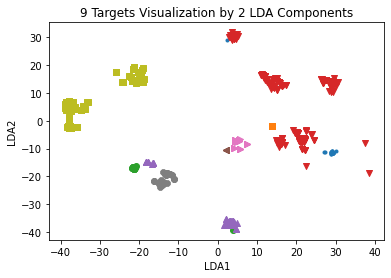

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'tsne_x'], y = df.loc[j, 'tsne_y'], marker = i)

plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.title('9 Targets Visualization by 2 LDA Components')
plt.show()

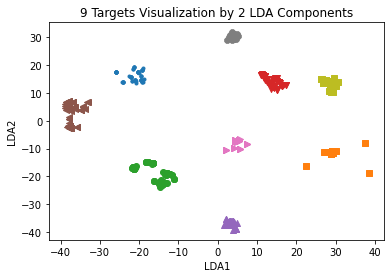

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'tsne_x'], y = df.loc[j, 'tsne_y'], marker = i)

plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.title('9 Targets Visualization by 2 LDA Components')
plt.show()

In [27]:
km2 = KMeans(n_clusters = 10, max_iter = 1000)
km2.fit(df[['tsne_x', 'tsne_y']])
cal_accuracy(df['target'], km2.labels_)

0.8309138109546513